In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iism_lab3 import poisson_psi, exponential_psi, normal_psi
%matplotlib inline

In [23]:
psi1 = poisson_psi()
res1 = np.array([next(psi1) for _ in range(1000)])
print("Распределение Пуассона")
print("E =", np.mean(res1))
print("D =", np.std(res1))

Распределение Пуассона
E = 1.016
D = 1.02846682008


[  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.00000000e-18
   1.00000000e-18   0.00000000e+00   1.00000000e-18   3.00000000e-18
   1.00000000e-18   1.00000000e-18   0.00000000e+00   0.00000000e+00
   1.00000000e-18   4.00000000e-18   0.00000000e+00   1.00000000e-18
   1.00000000e-18   0.00000000e+00   1.00000000e-18   0.00000000e+00
   2.00000000e-18   1.00000000e-18   1.00000000e-18   1.00000000e-18
   1.00000000e-18   0.00000000e+00   1.00000000e-18   0.00000000e+00
   0.00000000e+00   1.00000000e-18   0.00000000e+00   1.00000000e-18
   2.00000000e-18   0.00000000e+00   2.00000000e-18   0.00000000e+00
   4.00000000e-18   2.00000000e-18   1.00000000e-18   3.00000000e-18
   1.00000000e-18   1.00000000e-18   2.00000000e-18   1.00000000e-18
   1.00000000e-18   1.00000000e-18   1.00000000e-18   0.00000000e+00
   2.00000000e-18   4.00000000e-18   1.00000000e-18   5.00000000e-18
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e-18
   1.00000000e-18   0.00000000e+00

ValueError: x and y must have same first dimension

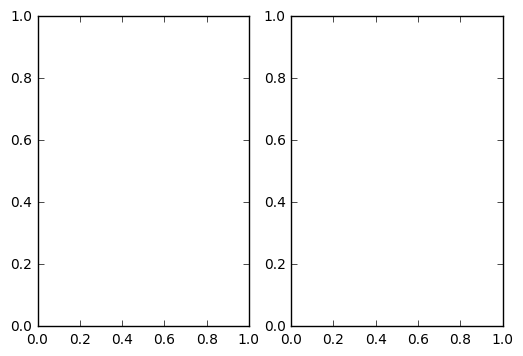

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2)
# axes[0].hist(res1 / len(res1), bins=4)len(res1)

axes[1].hist(res1, bins=4)
axes[1].plot([i for i in range(6)], 
             [1 / np.math.factorial(i) / np.exp(1) for i in range(6)],
             color='r')

In [9]:
psi2 = normal_psi(12)
res2 = pd.Series([next(psi2) for _ in range(1000)])
print("Нормальное распределение")
print("E =", np.mean(res2))
print("D =", np.std(res2))

Нормальное распределение
E = -0.00611609756098
D = 0.979449180093


In [11]:
psi3 = exponential_psi()
res3 = pd.Series([next(psi3) for _ in range(1000)])
print("Экспоненциальное распределение")
print("E = ", np.mean(res3))
print("D = ", np.std(res3))

Экспоненциальное распределение
E =  0.486803277661
D =  0.44626064994
